# Tutorial 4: *High-dimensional* inverse Poisson problem
## Using *variational* Bayes


In the last tutorial you considered the inverse Poisson's equation with a diffusion coefficient $\alpha(x)$ parameterized by a function with a small number of parameters.  In this setting McMC was feasible - but you saw the increase in cost as the number of parameters increased.  Instead here we want to consider the case where $\alpha(x)$ is modelled much more generally - as a Gaussian process.

First we reproduce some of the code of the previous tutorial.  Again Poisson's equation in 1d with a diffusion coefficient $\alpha(x)$, and source term $f(x)$ is:
$$
\frac{\partial}{\partial x} \left( \alpha(x) \frac{\partial u}{\partial x}\right) = 0,\quad\mathrm{on}\:\:[0, 1]
$$
with Dirichlet boundary conditions
$$
u(0) = U_0 = 1,\quad u(1) = U_1 = 6.
$$

This project will take you through the following steps:

1. **Bayesian modelling**: Build a statistical model for the data-simulation problem (with a Gaussian process this time)
1. **Posterior gradients**: Evaluate derivatives of the posterior density with adjoint method.
1. **Inverse problem**: Solve for the MAP-estimate of $\alpha$ with gradient-based optimization.

In [47]:
%matplotlib inline
import copy, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, linregress, lognorm
from scipy.optimize import minimize
from scipy.io import loadmat
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

## 1. Forward problem: Discretization

Same as last Tutorial:

In [48]:
## Alvaro says that the FD Poisson solver is incorrect in Tutorial 4:

# def poisson_matrix(alpha):
#     """
#     Compute the tri-diagonal Poisson matrix on domain x \in [0,1], assuming uniform grid.
    
#     Args:
#         alpha (array): Value of dissipation coefficient at every grid node.  Shape (N+1,).
#     Return:
#         A (sparse matrix): 
#     """
#     N = alpha.shape[0] -1
#     diag, upper, lower = np.ones(N+1), np.zeros(N), np.zeros(N) 
#     upper[1:]  =  0.5 * (alpha[1:-1]                  + alpha[2:  ])
#     diag[1:-1] = -0.5 * (alpha[ :-2]  + 2*alpha[1:-1] + alpha[2:  ])
#     lower[:-1] =  0.5 * (alpha[ :-2]                  + alpha[1:-1])
#     return sparse.diags([lower,diag,upper], [-1,0,1]).tocsr()

# def solve_poisson(alpha, rhs, U0, U1):
#     """Solve Poisson with specified conditions."""
#     N = alpha.shape[0] -1
#     if not type(rhs) is np.ndarray: rhs = np.ones(N+1) * rhs
#     rhs[0], rhs[-1] = U0, U1
#     h = 1./ N
#     rhs *= h**2
#     A = poisson_matrix(alpha)
#     return linalg.spsolve(A, rhs)

# U0, U1 = 1., 6.

## Copied over Poisson solver from Tutorial 3 (advice from Alvaro):


def poisson_matrix(alpha):
    """
    Compute the tri-diagonal Poisson matrix on domain x \in [0,1], assuming uniform grid.
    
    Args:
        alpha (array): Value of dissipation coefficient at every grid node.  Shape (N+1,).
    Return:
        A (sparse matrix): 
    """
    N = alpha.shape[0] -1
    h     = 1./N
    scale = 1./(2.*h**2)
    diag, upper, lower = np.ones(N+1), np.zeros(N), np.zeros(N) 
    upper[1:]  =  scale * (alpha[1:-1]                  + alpha[2:  ])
    diag[1:-1] = -scale * (alpha[ :-2]  + 2*alpha[1:-1] + alpha[2:  ])
    lower[:-1] =  scale * (alpha[ :-2]                  + alpha[1:-1])
    return sparse.diags([lower,diag,upper], [-1,0,1]).tocsr()

def solve_poisson(alpha, rhs, U0, U1):
    """Solve Poisson with specified conditions."""
    if not type(rhs) is np.ndarray: rhs = np.zeros(len(alpha))
    rhs[0], rhs[-1] = U0, U1
    A = poisson_matrix(alpha)
    return linalg.spsolve(A, rhs)

U0, U1 = 1., 6.

## 2. Bayesian modelling

Now consider again the inverse problem of determining an unknown function $\alpha(x)$, given *observations* $\boldsymbol{d}$ of $u(x)$.  We use Bayesian methodology - as in the last tutorial, and formally the expression for the posterior distribution is unmodified:
$$
\rho(\boldsymbol{\alpha} | \boldsymbol{d}) \propto \rho(\boldsymbol{d} | \boldsymbol{\alpha}) \cdot \rho_0(\boldsymbol{\alpha}).
$$

### Prior
$\newcommand{\alphab}{\boldsymbol{\alpha}}$
Given that $\alpha(x)$ is a function (of space), it's reasonably that we model it stochastically with a *random function*.  In the lectures and tutorial on Kriging we covered a class of random functions called Gaussian random fields
$$
Y \sim \mathcal{GP}(\mu(x), \sigma^2_Y r(\cdot,\cdot))
$$
which are characterized by a mean $\mu(x)$ and a covariance function $r(x_i,x_j)$ that describes the correlation between the points $x_i$ and $x_j$ as:
$$
r(x_i, x_j) = \mathrm{Cov}(Y(x_i), Y(x_j)).
$$
This is true for all $x_i$, $x_j$ so that if we ``discretize'' the Gaussian process $Y$ at $\boldsymbol{x} = [x_0,\dots,x_N]$ the resulting random variable is (multivariate) normal:
$$
\alphab \sim \mathcal{N}(\boldsymbol{\mu}, P),\quad\boldsymbol{\mu}_i := \mu(x_i),\quad  P\in\mathbb{R}^{(N+1)\times (N+1)},\quad P_{ij} = r(x_i,x_j).
$$
So far this is identical to the Tutorial on Kriging.  If we want to now ensure that $\boldsymbol{\alpha}$ is always positive we can consider a log-normal prior 
$$
\boldsymbol{\alpha} = e^\boldsymbol{\beta},\:\boldsymbol{\beta}\sim\mathcal{N}(\mu(\boldsymbol{x}),P) \implies \boldsymbol{\alpha} \sim \mathrm{log}\mathcal{N}(\mu(\boldsymbol{x}), P),
$$
with pdf:
$$
\rho(\boldsymbol{\alpha}) \propto \left(\prod_{i=0}^N \frac{1}{\boldsymbol{\alpha}_i}\right) \cdot \exp\left\{ -\frac{1}{2} (\log\boldsymbol{\alpha} - \boldsymbol{\mu})^T P^{-1} (\log\boldsymbol{\alpha} - \boldsymbol{\mu}) \right\}.
$$


**EXERCISE 1**

Implement a Gaussian-process with a log-normal prior.  

(a) The `scipy` module does not implement multi-variate log-normal natively, so implement the log-pdf (from the above definition) in `logpdf()` below.  Be careful to return a reasonable value when any component of `x` is negative.  Also implement random-sampling in `rvs()`.  The latter is done by sampling a multivariate normal `scipy.stats.multivariate_normal`, and then taking the exponent.  [Why do you think we work with the *log* pdf?] 

**Note:** To simplify the code we use Python classes here.  Below is a template.  Note that `self.` is the way to refer to class members (variables and functions) when working within the class.  So when `__init__()` is called (automatically when the class is instantized), the variables `mu`, `Sigma` etc. are stored in the class for future use.

----
we work with log-pdf due to simpler algebra (adding exponents more convenient than multiplying) and reduced risk of round-off errors (prevalent for regions of low-probability)

To ensure that log(x) remains defined, log(|x|) is used.

In [49]:
# INCORRECT, as log pdf of multivariate normal was being taken (instead of log pdf of log normal)

# class multivariate_lognormal:
#     """
#     Multivariate lognormal distribution.  Distribution of Y = exp(X), where
#     X ~ N(mu, Sigma), for general mean and covariance matrix Simga.

#     Args:
#       mu (array): Mean of underlying normal distribution, shape (N,).
#       Sigma (array): Covariance of underlying normal, shape (N,N).
#     """
#     def __init__(self, mu, Sigma):
#         self.mu, self.Sigma = mu, Sigma
#         self.invSigma = np.linalg.inv(Sigma)
#         self.mvn = multivariate_normal(mu, Sigma, allow_singular=True)
#     def logpdf(self, x):
#         """Return log-pdf of log-normal RV at x (array, shape N)"""
#         try:
#             logpdf_values = self.mvn.logpdf(x)
#         except x <= 0:
#             logpdf_values = self.mu*np.ones(len(x))
#             print('WARNING: x is negative. Mean value returned!')
#         return (logpdf_values)
#     def rvs(self):
#         """Return single random sample from log-normal RV"""
#         samples = self.mvn.rvs()
#         return samples

class multivariate_lognormal:
    """
    Multivariate lognormal distribution.  Distribution of Y = exp(X), where
    X ~ N(mu, Sigma), for general mean and covariance matrix Simga.

    Args:
      mu (array): Mean of underlying normal distribution, shape (N,).
      Sigma (array): Covariance of underlying normal, shape (N,N).
    """
    def __init__(self, mu, Sigma):
        self.mu, self.Sigma = mu, Sigma
        self.invSigma = np.linalg.inv(Sigma)
        self.mvn = multivariate_normal(mu, Sigma, allow_singular=True)
    # def logpdf(self, x):
    #     """Return log-pdf of log-normal RV at x (array, shape N)"""
    #     try:
    #         self.pdf = np.prod(1 / x)*np.exp(-0.5*(np.log(x)-self.mu).T @ self.invSigma @ (np.log(x)-self.mu))
    #     except np.any(x) <= 0:
    #         x = np.ones(len(self.mu))
    #         self.pdf = np.prod(1 / x)*np.exp(-0.5*(np.log(x)-self.mu).T @ self.invSigma @ (np.log(x)-self.mu))
    #         print('WARNING: x is negative. x=1 is used instead!')
    #     logpdf_values = np.log(self.pdf)
    #     return (logpdf_values)

    def logpdf(self, x):
        """Return log-pdf of log-normal RV at x (array, shape N)"""
        x = np.sqrt(x*x)
        self.pdf = np.prod(1 / x)*np.exp(-0.5*(np.log(x)-self.mu).T @ self.invSigma @ (np.log(x)-self.mu))
        logpdf_values = np.log(self.pdf)
        return (logpdf_values)
    
    def rvs(self):
        """Return single random sample from log-normal RV"""
        samples = self.mvn.rvs()
        return np.exp(samples)
    
    def dlogpdf(self, x): # for ex. 3, necessary to compute dI/dalpha
        """computes the derivative of the log prior pdf"""
        # c = 0
        # for i in range(x):
        #     c -= 1/x[i]
        # dlogpdf = c -1/alpha[i] * (np.log(alpha[i])-mu)/(sigma_R**2)

        # attempt 1: neglecting the product term
        # dlogpdf = -0.5 * (np.log(x)-self.mu).T @ (self.invSigma + self.invSigma.T) @ 1/x

        # attempt 2: including the derivative of the log product
        # dlogpdf = -0.5 * (np.log(x)-self.mu).T @ (self.invSigma + self.invSigma.T) @ 1/x - 1/x

        # attempt 3: slides (lecture G)
        dlogpdf = - self.invSigma @ (np.log(x)-self.mu) #* 1/x 
        return dlogpdf

# Basic tests of implementation - necessary but not sufficient for correctness!
mu = np.array([1.,2.])
P = np.array([[1., .5],
              [.5, 2.]])
y = multivariate_lognormal(mu, P)
x = np.array([2.,1.])   
print(f'y.logpdf(x): {y.logpdf(x)}')
assert np.isclose(y.logpdf(x), -1.71446479962)  # Test logpdf 
assert y.rvs().shape == (2,)  # Test rvs output (for full test, plot the histogram)

y.logpdf(x): -1.7144647996218059


(b) The following code evaluates the prior covariance matrix, as in the previous tutorial (`distances()` is analogous to `dist2()` there), but this time with a variety of covariance functions.  The goal is to investigate the effect of the settings, and find settings might be a good prior for $\boldsymbol{\alpha}$.  To do this vary the covariance function, the correlation-length `l`, the standard-deviation `sigma`, the mean `mu`, and whether the process is normal or log-normal.  Examine the results by plotting ~10 random samples from the process for each setting.

----
Distance is raised to the power of the exponent. Therefore, the process is normal (double check)

Good settings: squared exponential (as it is smooth). Let's use l = 1 to ensure high degree of smoothness (for x in [0,1])

(Text(0.5, 0, 'x'), Text(0, 0.5, 'distance'))

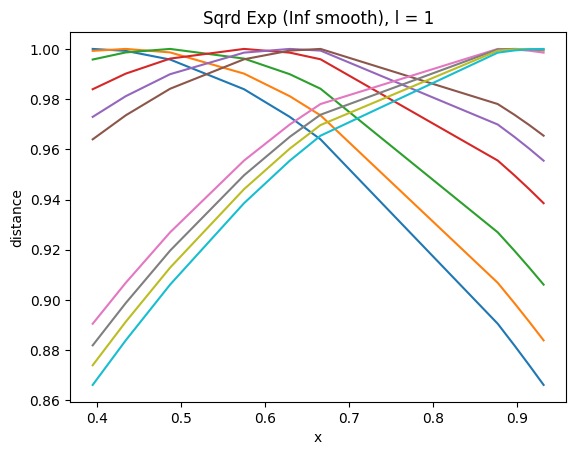

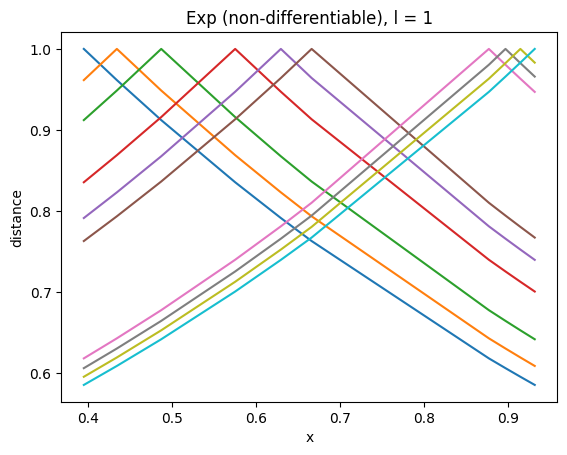

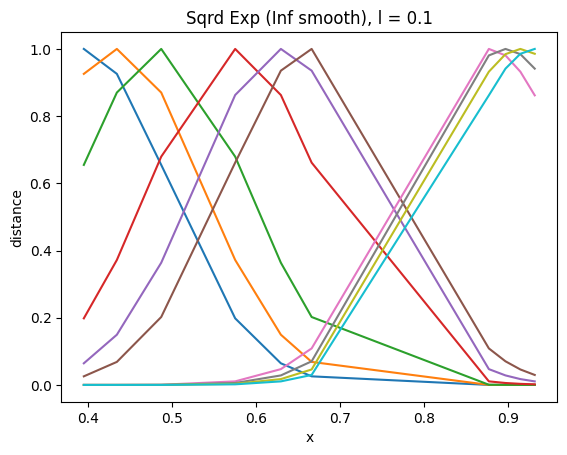

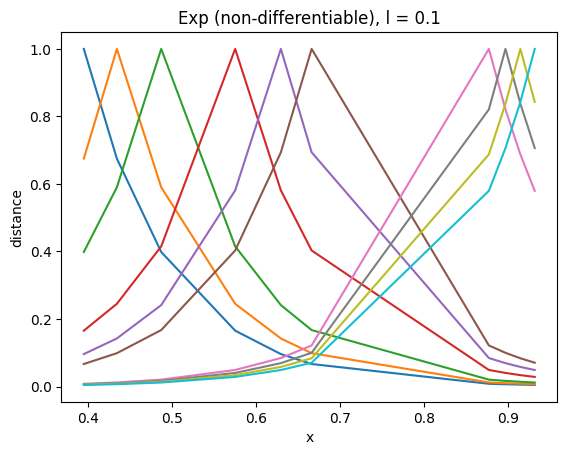

In [50]:
def distances(x):
    """Return matrix of distances between all pairs of nodes in 1-dimension,
    i.e. |x_i - x_j| for all i,j in {0,...,N}.
    """
    N = x.shape[0]
    return np.abs(np.einsum('i,j', x, np.ones(N)) - np.einsum('i,j', np.ones(N), x))

def covariancefn_identity(x, l):
    """White-noise covariance - no correlation between neighbouring points"""
    d = distances(x)
    return np.where(d < 1.e-8, 1.,0.)
def covariancefn_squaredexponential(x, l):
    """Infinitely-differentiable (in xi) covariance - infinitely smooth"""
    d = distances(x)
    return np.exp(-d**2/ (2 * l**2))
def covariancefn_matern_12(x, l):
    """Matern nu=1/2 - continuous, non-differentiable covariance - rough"""
    d = distances(x)
    return np.exp(-d/l)

N_samples  = 10 
x = np.sort(np.random.rand(N_samples)) # np.random.rand(N_samples) #np.linspace(0,1, 10)

# test settings
dist1 = covariancefn_squaredexponential(x, l = 1)
dist2 = covariancefn_matern_12(x, l = 1)

dist3 = covariancefn_squaredexponential(x, l = 0.1)
dist4 = covariancefn_matern_12(x, l = 0.1)

plt.figure()
plt.title("Sqrd Exp (Inf smooth), l = 1")
plt.plot(x, dist1)
plt.xlabel('x'), plt.ylabel('distance')

plt.figure()
plt.title("Exp (non-differentiable), l = 1")
plt.plot(x, dist2)
plt.xlabel('x'), plt.ylabel('distance')

plt.figure()
plt.title("Sqrd Exp (Inf smooth), l = 0.1")
plt.plot(x, dist3)
plt.xlabel('x'), plt.ylabel('distance')

plt.figure()
plt.title("Exp (non-differentiable), l = 0.1")
plt.plot(x, dist4)
plt.xlabel('x'), plt.ylabel('distance')



### Likelihood

An expression for $\rho(\boldsymbol{d} | \boldsymbol{\alpha})$ can be obtained from a statistical model.  Here we use a (standard) model with additive observation noise:
$$
d_j = u(\hat x_j) + \epsilon_j,\quad \epsilon_j \sim \mathcal{N}(0, \sigma_d^2),\quad j\in\{1,\dots,M\}
$$
where the *observation noise* in observation $d_j$ is $\epsilon_j$, which is modelled as unbiased Gaussian noise with standard-deviation $\sigma_d$, and $\hat x_j \in [0,1]$ is the location of the $j$-th observation (not necessarily a grid node).  In discrete form:
$$
\boldsymbol{d}= H(\boldsymbol{u}) + \boldsymbol{\epsilon},\quad \boldsymbol{\epsilon}\sim\mathcal{N}(0,R)
$$
where $H(\cdot): \mathbb{R}^N\rightarrow\mathbb{R}^M$ is the observation operator that extracts an approximation of $u(\hat x_j)$ from $\boldsymbol{u}$ (by piecewise-linear interpolation using `numpy.interp()` in our implementation).  By rearranging
$$
\boldsymbol{d} -H(\boldsymbol{u})\sim \mathcal{N}(0,R)
$$
so the resulting expression for the likelihood is
$$
\rho(\boldsymbol{d} | \boldsymbol{\alpha}) = \rho_\epsilon\left(\boldsymbol{d} - H(\boldsymbol{u}) \right) \propto \exp\left\{-\frac{1}{2}(\boldsymbol{d} - H(\boldsymbol{u}))^T R^{-1}(\boldsymbol{d} - H(\boldsymbol{u}))\right\}.
$$
where throughout $\boldsymbol{u}$ always satisfies the discrete problem exactly: $\boldsymbol{R}(\boldsymbol{u};\boldsymbol{\alpha}) = 0$. [Alternatively, we can regard $\boldsymbol{u}$ as a function of $\boldsymbol{\alpha}$, i.e. $\boldsymbol{u} := \boldsymbol{u}(\boldsymbol{\alpha})$.]

**EXERCISE 2**

Starting from the pdfs for likelihood, and your chosen log-normal prior, derive an explicit expression for the log-posterior $\log \rho(\boldsymbol{\alpha} | \boldsymbol{d})$ in terms of $\boldsymbol{\alpha}$, $\boldsymbol{u}$ and $\boldsymbol{d}$. (Do this first on paper.)

Implement the posterior in the following class-template in the method `compute_I(self,alpha)`.  This will involve solving the Poisson equation for the argument `alpha` by calling `solve_poisson()`.  You can reuse the prior log-pdfs implemented in `multivariate_lognormal` by calling `self.prior.logpdf(alpha)`.  Already provided are: the `H` operator (implemented with piecewise linear interpolation), a method to compute the associated matrix `Hmatrix`, and some functions that will be used later in Tutorial 5 (like `compute_gradient_findiff()`).


In [51]:
class ObjectiveFn:
    """
    Compute the objective function I - the logarithm of the posterior
    density for the Poisson diffusion coefficient (alpha).

    Args:
      x (array): Mesh points on which the simulation model is defined
      rhs (array): Right-hand side of Poisson equation at mesh points
      bc1,bc2 (float): Boundary-conditions, left and right
      x_obs (array): x-locations of the observations
      u_obs (array): Observations of the soluton at `x_obs`
      noise (float): Estimated measurement noise in obsevations
      prior (multivariate_lognormal): Prior for `alpha` - instance of your
                                      lognormal class.
    """
    def __init__(self, x, rhs, bc1, bc2, x_obs, u_obs, noise, prior):
        self.N = len(x)-1    # Number of mesh cells (number of nodes - 1)
        self.M = len(x_obs)  # Number of observations
        self.x = x
        self.rhs, self.bc1, self.bc2 = rhs, bc1, bc2
        self.x_obs, self.u_obs, self.noise = x_obs, u_obs, noise
        self.prior = prior
        self.Hmatrix = self.compute_H_matrix()
        self.Rmatrix = np.diag(np.ones(self.M)*self.noise)
        self.invRmatrix =  np.linalg.inv(self.Rmatrix)
        
    def H(self, u):
        """
        Observation operator for model (piecewise-linear interpolation of 
        state at observation locations).
        """
        return np.interp(self.x_obs, self.x, u, left=self.bc1, right=self.bc2)

    def compute_H_matrix(self):
        """
        Generate matrix version of observation operator - by finite-differences.
        Assumes self.H() is a linear operator.
        """
        Hmat = np.zeros( (self.M, self.N+1) )
        utest = np.zeros( self.N+1 )
        for i in range(self.N+1):
            utest[i] = 1
            Hmat[:,i] = self.H(utest)
            utest[:] = 0
        return Hmat
    
    def compute_I(self, alpha):
        logpdf_prior = self.prior.logpdf(alpha)
        # logpdf_likelihood = 0.5* (self.x_obs-self.Hmatrix).T @ self.Rmatrix @ (self.x_obs-self.Hmatrix)
        u = solve_poisson(alpha, 0., U0, U1) 
        logpdf_likelihood = -0.5* (self.x_obs-self.H(u)).T @ self.invRmatrix @ (self.x_obs-self.H(u))
        const = 0 # UNSURE: about the value of constant that should be used for log addition. For now, kept it to zero for convenience.
        # const = np.sum(np.log(alpha))*-1            
        return logpdf_prior + logpdf_likelihood + const
    
    def negated_compute_I(self, alpha):
        return -self.compute_I(alpha)
    
    
    ### To be used later...
    def compute_gradient_adjoint(self, alpha):
        """
        Compute total dI/dalpha by adjoint (cost: 1 forward, 1 adjoint solve)
        """
        u        = solve_poisson(alpha, self.rhs, self.bc1, self.bc2)
        dIdu     = self.compute_dIdu(alpha, u)
        dIdalpha = self.compute_dIdalpha(alpha)
        dRdalpha = compute_dRdalpha(u)
        psi      = solve_poisson_adjoint(alpha, dIdu)
        # return -dIdalpha - dRdalpha.T.dot(psi[1:-1])
        return (-dIdalpha - dRdalpha.T.dot(psi))*2
    
    def negated_compute_gradient_adjoint(self, alpha):
        return -self.compute_gradient_adjoint(alpha)
    
    def compute_gradient_findiff(self, alpha, epsilon=1.e-5):
        """
        Compute total dI/dalpha by finite-differences (cost: N+2 forward solves)
        """
        dIdalpha = np.zeros(self.N+1)
        Ibase = self.compute_I(alpha)
        for i in range(self.N+1):
            alpha[i] += epsilon             # Perturb alpha
            I = self.compute_I(alpha)
            dIdalpha[i] = (I - Ibase) / epsilon
            alpha[i] -= epsilon             # Restore alpha
        return dIdalpha
    
    def compute_dIdu(self, alpha, u):
        """
        Compute partial dI/du 
        """
        # dIdu = np.zeros(len(alpha))
        # attempt 1 (derived)
        # dIdu = -0.5 * (self.x_obs-self.H(u)).T @ (self.invRmatrix + self.invRmatrix.T) 

        # attempt 2 (from slides, lecture G)
        # Hmat = np.zeros( (self.M, self.N+1) )
        # for i in range(self.N+1):
        #     Hmat[:,i] = self.H(u)

        Hmat = np.zeros( (self.M, self.N+1) )
        utest = np.zeros( self.N+1 )
        for i in range(self.N+1):
            utest[i] = 1
            Hmat[:,i] = self.H(utest)
            utest[:] = 0
        dIdu = Hmat.T @ self.invRmatrix @ (self.x_obs-self.H(u)) 
        # dIdu = self.invRmatrix @ (self.x_obs-self.H(u)) 

        # Rmatrix = np.diag(np.ones(len(alpha))*self.noise)
        # Rmatrix = np.diag(np.ones(self.N)*self.noise)
        # invRmatrix =  np.linalg.inv(self.Rmatrix)
        # # # attempt 3 (from slides, lecture G... corrected dimensions)
        # print(f'shape invRmatrix: {np.shape(invRmatrix)}, len x: {len(self.x)}, len H(u): {len(self.H(u))}')
        # dIdu = invRmatrix @ (self.x-self.H(u)) 
        return dIdu
    
    def compute_dIdalpha(self, alpha):
        """
        Compute partial dI/dalpha 
        """
        # dIdalpha = np.zeros(len(alpha))
        dlogpdf = self.prior.logpdf(alpha)
        dIdalpha = dlogpdf
        return dIdalpha
    

**EXERCISE 3**

We now verify your implementation by means of a *twin-problem* in the following steps: 

1. Choose a particular $\alpha_\mathrm{ref}(\cdot)$.
- Generate a reference solution `u_ref` on a very fine grid `x_ref` with this $\alpha$.
- Get "data" by sampling `u_ref` at a few observation locations `x_obs`.
- Now build your objective function with a standard grid `x_sim`, and evaluate the posterior for some new $\alpha_\mathrm{test}$.

Of course your posterior should be maximum where $\alpha_\mathrm{test} = \alpha_\mathrm{ref}$.
Unfortunately, your estimate of $\alpha$ has the same number of DoFs as your grid `x_sim`, so the posterior is a function from $\mathbb{R}^{100}$ to $\mathbb{R}$, and plotting it is... difficult.  For now, we assume we know $\alpha$ has the form:
$$
\alpha(x; a, f) = a \sin(2\pi f x) + \frac{6}{10}
$$
i.e. a function of 2 variables: an amplitude $a$ and frequency $f$.  Then we can plot the posterior probability as a function of $a$ and $f$.  The following code does this.   Run it, and verify that the posterior is reasonable according to your expectations.  Also - why is there a white region on the plot?  Is the result very sensitive to your choice of prior?  Is this a "good" or a "bad" thing?

[Note: Normally the values of the log-posterior are very small $-1\times 10^8$ is not unusual.  Therefore we actually plot contours of $\log [\rho(\boldsymbol{\alpha} | \boldsymbol{d})]$ in order to squash the range a little.  As always in these problems only *relative* probabilities are important.]

-----

White regions appear due to runtime errors, specifically in the computation of $log(-pdf)$, if $pdf > 0$. 

The set of parameters (amplitude, frequency) are highly sensitive to the statistical properties $\left(\mu, \sigma, l\right)$ of the prior. This means that it is difficult to correlate a set of parameters $\alpha$, for a given set of data $d$, as said data itself is highly on the prior. 




C:\Users\ndigh\AppData\Local\Temp\ipykernel_13136\1751228891.py:57: RuntimeWarning: divide by zero encountered in log
  logpdf_values = np.log(self.pdf)


Text(0, 0.5, 'Frequency')

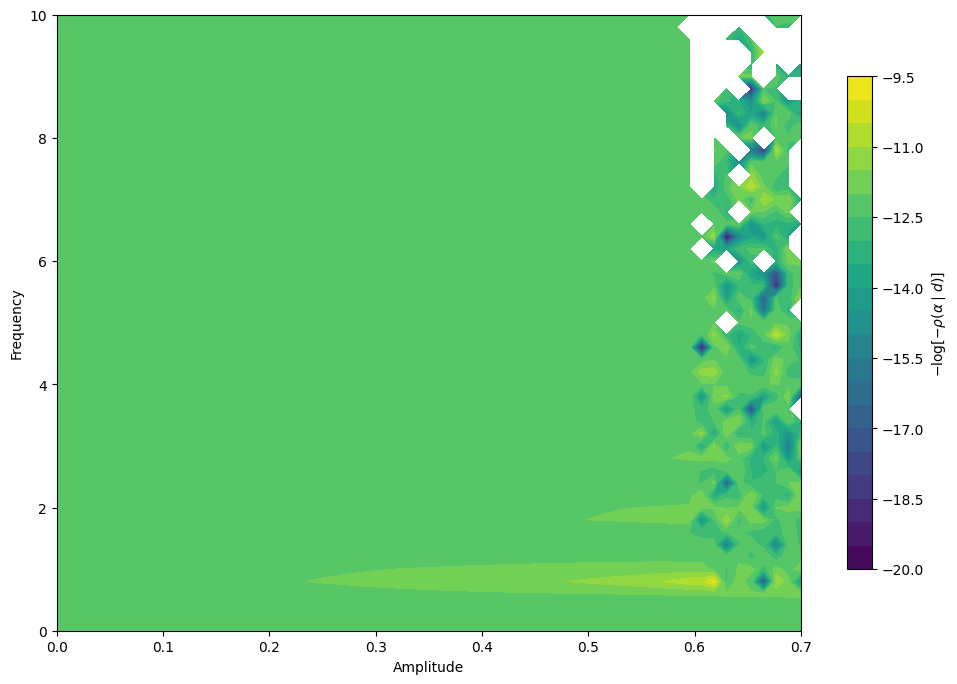

In [52]:
def alpha_sin(x, amplitude, frequency):
    return amplitude*np.sin(2*frequency*np.pi*x) + .6

# Reference grid, observation locations and simulation grid respectively
x_ref = np.linspace(0,1,10001)
x_obs = np.linspace(0,1,40)
x_sim = np.linspace(0,1,101)

# Reference solution sampled at the observation points
# This defines our reference for alpha with amplitude=0.55, frequency=5.
alpha_ref = alpha_sin(x_ref, amplitude=0.55, frequency=5.)
u_ref = solve_poisson(alpha_ref, 0., U0, U1)
u_obs = np.interp(x_obs, x_ref, u_ref, left=U0, right=U1)
noise = 0.001

# Lognormal Prior - feel free to change these and see the effect
# mu_0, sigma_0, l = 0.5, 1., .01
# mu_0, sigma_0, l = 0.5, 3., 1
mu_0, sigma_0, l = 0, 1, 0.2

mu_prior = mu_0*np.ones(x_sim.shape[0])
P = sigma_0**2 * covariancefn_matern_12(x_sim, l)
prior = multivariate_lognormal(mu_prior, P)

# Initialize your objective function with the above data
objfn = ObjectiveFn(x_sim, 0., U0, U1, x_obs, u_obs, noise, prior)

# Plotting code
amplitude_plot = np.linspace(0.,0.7, 61)
frequency_plot = np.linspace(0.,10, 51)
Amp,Freq = np.meshgrid(amplitude_plot, frequency_plot)
Pdf = np.zeros(Amp.shape)
for i in range(51):
    for j in range(61):
        # Evaluate the objective fn for a specific alpha
        alpha = alpha_sin(x_sim, Amp[i,j], Freq[i,j])
        Pdf[i,j] = objfn.compute_I(alpha)
plt.figure(figsize=(12,8))
CS = plt.contourf(Amp, Freq, -np.log(-Pdf), 21)
cbar = plt.colorbar(CS, shrink=0.8, extend='both')
cbar.ax.set_ylabel(r'$-\log[-\rho(\alpha\mid d)]$')
plt.xlabel('Amplitude'); plt.ylabel('Frequency')


## Gradient-based optimization with adjoints
$$
\newcommand{\dif}{\mathrm{d}}
\newcommand{\db}{\mathbf{u}}
\newcommand{\ub}{\mathbf{u}}
\newcommand{\Rb}{\mathbf{R}}
\newcommand{\alphab}{\boldsymbol{\alpha}}
\newcommand{\psib}{\boldsymbol{\psi}}
\newcommand{\dxdx}[2]{{\frac{\partial #1}{\partial #2}}}
\newcommand{\tdxdx}[2]{ \frac{\dif{#1}}{\dif{#2}}}  %Leibniz derivative
$$
Of course in reality we don't know the form of $\alpha$, and would like to estimate the complete function from the observations.  Even though we have an explicit expression for the posterior, extracting useful information from this high-dimensional function is difficult.  Therefore we satisfy ourselves with computing the Maximum A Priori (MAP) value - i.e. the $\alpha$ which maximizes the posterior:
$$
\alpha_\mathrm{MAP} := \mathrm{argmax}_\alpha \log \rho(\alpha\mid d).
$$
However, even this optimization problem is difficult when $\alpha$ is high-dimensional - we need gradient-based optimization, so we need gradients:
$$
\frac{d}{d\alpha} I := \frac{d}{d\alpha}\left\{ \log \rho(\alpha\mid d) \right\}.
$$
This is a vector of the same dimension as $\alphab$ (since $I$ is a scalar).  Note that $I = I(\alphab, \ub(\alphab))$ can be considered a function of both $\ub$ and $\alphab$, but also only a function of $\alphab$, since $\ub = \ub(\alphab)$.  There is therefore a fundamental difference between the partial derivative $\partial I/\partial \alphab$ (at constant $\ub$), and the total derivative $\dif I/\dif \alphab$ which includes the variation of $\ub$ due to variation in $\alphab$.  The former can be written down directly - given the explicit expression for $I$ (from the previous exercise); the latter requires the solution of a linear system to evaluate.  Throughout the observations $\db$ are constants.

A naive approach to evaluating $\dif I/\dif\alpha_i$ might be to directly use the chain rule:
$$
\tdxdx{I}{\alpha_i} = \dxdx{I}{\alpha_i} + \dxdx{I}{\ub}\tdxdx{\ub}{\alpha_i}, \quad i\in\{0,\dots N\},
$$
and differentiating $\Rb(\ub; \alpha_i) = 0$ (the Poisson governing equation in discrete form) gives a linear system to solve for $\dif\ub/\dif\alpha_i$:
$$
\dxdx{\Rb}{\alpha_i} + \dxdx{\Rb}{\ub} \tdxdx{\ub}{\alpha_i} = 0.
$$
The disadvantage of this approach is that $N+1$ linear systems must be solved to obtain all $\dif I/\dif\alpha_i$.

The alternative is to use the so-called *adjoint* approach.  First define the *Lagrangian* 
$$
L(\alphab; \psib) = I(\alphab, \ub) + \psib^T \Rb(\ub, \alphab),
$$
where $\psib$ is known as the {\it adjoint} vector.  Note that $L \equiv I$, independently of the value of $\psib$ and $\alphab$, provided that $\ub$ satisfies the governing equations $\Rb(\ub,\alphab)=0$.  Since this is true for all $\alphab$ we also have:
$$
\tdxdx{L}{\alphab} = \tdxdx{I}{\alphab}.
$$
Using this we can write:

\begin{align}
\tdxdx{I}{\alpha_i} = \tdxdx{L}{\alpha_i} &= \frac{\dif}{\dif\alpha_i}\left[ I + \psib^T \Rb\right] \\
                        &= \dxdx{I}{\alpha_i} + \dxdx{I}{\ub}\tdxdx{\ub}{\alpha_i} + \psib^T\left[\dxdx{\Rb}{\alpha_i} + \dxdx{\Rb}{\ub}\tdxdx{\ub}{\alpha_i} \right] \\
                        &= \dxdx{I}{\alpha_i} + \psib^T\dxdx{\Rb}{\alpha_i} + \left[\dxdx{I}{\ub} + \psib^T\dxdx{\Rb}{\ub}\right] \tdxdx{\ub}{\alpha_i}.
\end{align}

The term $\dif \ub/\dif \alpha_i$ is still present in the expression for the derivative, but the freedom of choice of $\psib$ can be used to eliminate it.  Namely if $\psib$ satisfies the *adjoint equation*, 
$$
\psib^T\dxdx{R}{u} = -\dxdx{I}{u}.
$$
then the expression for the derivative reduces to
$$
\tdxdx{I}{\alpha_i} = \dxdx{I}{\alpha_i} + \psib^T\dxdx{\Rb}{\alpha_i}.
$$
Note that in this case only one linear system must be solved to obtain $\dif I/\dif\alpha_i$ for all $i$.





**EXERCISE 4**

(a) By differentiating your $I$ by hand, evaluate $\partial I/\partial \alphab$ and $\partial I/ \partial \ub$.  Since these are related to the objective function, implement them in the class `ObjectiveFn` by defining new member functions `compute_dIdalpha(self, alpha)` and `compute_dIdu(self, alpha, u)`.  They should both return numpy arrays of size $N+1$.  Note that for $\partial I/\partial \alphab$ you will also need to differentiate the expression for the prior pdf.  The most logical way to implement this by adding a member function `dlogpdf(self, x)` to the class `multivariate_lognormal`, and then calling it from `compute_dIdalpha()`.

(b) By differentiating $\Rb$ by hand, obtain an expression for $\partial\Rb/ \partial\alphab$.  Writing $\Rb$ as:

\begin{align*}
R_i(\ub; \alphab) &= \alpha_{i+1}\left(\frac{u_{i+1}-u_i}{4h^2}\right) 
+ \alpha_i     \left(\frac{u_{i+1}-2u_i+u_{i-1}}{4h^2}\right) 
                     + \alpha_{i-1} \left(\frac{u_{i-1}-u_i}{4h^2}\right) - f_i\\
                  &= u_{i+1}    \left(\frac{\alpha_{i+1}+\alpha_i}{4h^2}\right) 
                     - u_i         \left(\frac{\alpha_{i+1}+2\alpha_i+\alpha_{i-1}}{4h^2}\right) 
                     + u_{i-1}    \left(\frac{\alpha_i+\alpha_{i-1}}{4h^2}\right) - f_i.
\end{align*}

makes this more straight-forward.  Implement this in `compute_dRdalpha(u)` below, which should return a matrix of size $(N-1)\times (N+1)$ (since $\Rb$ is defined only at interior grid points, but depends on the value of $\alpha$ at all grid points), whereby most entries are zero.

(c) If everything is implemented correctly `ObjectiveFn.compute_gradient_adjoint()` should now work, and return the gradient of $I$ w.r.t. $\alpha$.  To check the result, setup a twin problem (as in the last exercise), plot this gradient, and gradients from `ObjectiveFn.compute_gradient_findiff()`.  This latter routine approximates $\dif I/\dif \alphab$ using finite differences:
$$
\tdxdx{I}{\alpha_i} \simeq \frac{I(\alphab + \epsilon \boldsymbol{e}_i) - I(\alphab)}{\epsilon},
$$
where $\boldsymbol{e}_i = (0, \cdots, 0, 1, 0, \cdots 0)$ is the unit-vector in the $i$-direction.  Vary `epsilon` to control the truncation error of the finite-differences.  Plot a comparison for several values of $\epsilon$. If adjoint and finite-difference do not agree, you have a bug!

Text(0.5, 0, 'u')

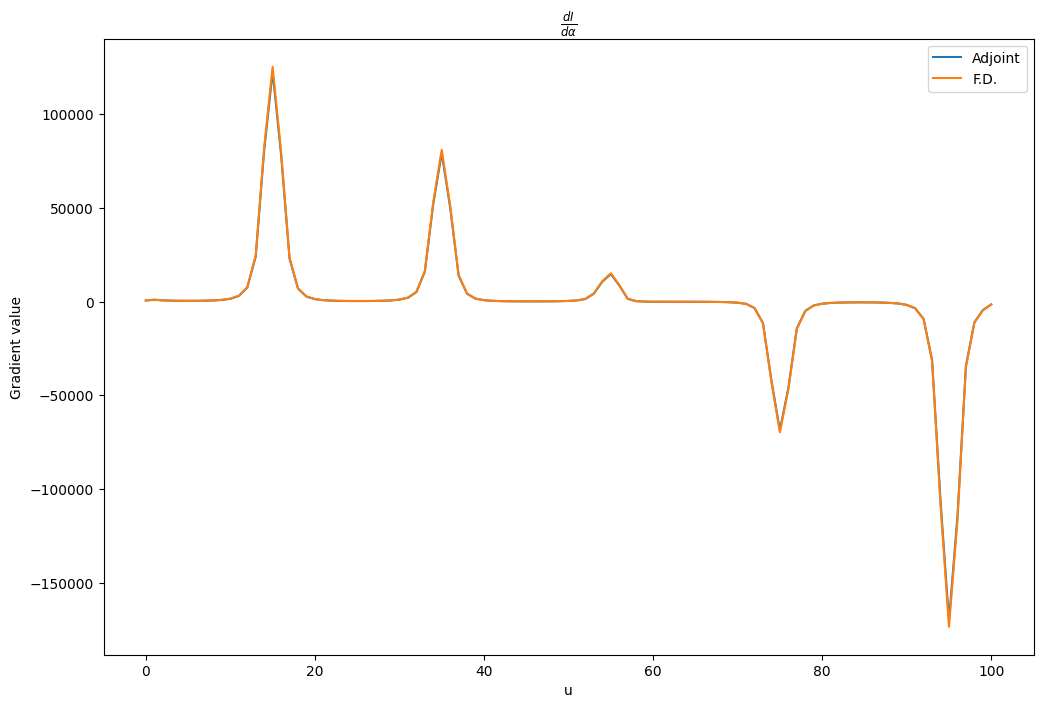

In [53]:
def solve_poisson_adjoint(alpha, dIdu):
    """Solve adjoint Poisson problem with specified conditions."""
    dIdu[0], dIdu[-1] = 0., 0.          # Due to Dirichlet BCs in primal solve
    At = poisson_matrix(alpha).T
    psi = linalg.spsolve(At, dIdu)
    psi[0] = psi[-1] = 0.
    return psi

def compute_dRdalpha(u):
    dRdalpha = np.zeros((len(u), len(u)))
    h = 1./(len(u)-2)

    for i in range(1, len(dRdalpha[0])-1):
        for j in range(len(dRdalpha[1])):
            # print(f'i = {i}, j = {j}')
            if i == j:
                dRdalpha[i, j] = 1/(4*h*h)*(u[i+1]-2*u[i]+u[i-1])
            elif i+1 == j:
                dRdalpha[i, j] = 1/(4*h*h)*(u[i+1]-u[i])
            elif i-1 == j:
                dRdalpha[i, j] = 1/(4*h*h)*(u[i-1]-u[i])
    return dRdalpha

### Setup twin problem
def alpha_sin(x, amplitude, frequency):
    return amplitude*np.sin(2*frequency*np.pi*x) + .6

# Reference grid, observation locations and simulation grid respectively
x_ref = np.linspace(0,1,10001)
x_obs = np.linspace(0,1,40)
x_sim = np.linspace(0,1,101)

# Reference solution sampled at the observation points
# This defines our reference for alpha with amplitude=0.55, frequency=5.
alpha_ref = alpha_sin(x_ref, amplitude=0.55, frequency=5.)
alpha_sim = alpha_sin(x_sim, amplitude=0.55, frequency=5.)
u_ref = solve_poisson(alpha_ref, 0., U0, U1)
u_obs = np.interp(x_obs, x_ref, u_ref, left=U0, right=U1)
noise = 0.001

# Lognormal Prior - feel free to change these and see the effect
# mu_0, sigma_0, l = 0.5, 1., .01
# mu_0, sigma_0, l = 0.5, 3., 1
mu_0, sigma_0, l = 0, 1, 0.2

mu_prior = mu_0*np.ones(x_sim.shape[0])
P = sigma_0**2 * covariancefn_matern_12(x_sim, l)
prior = multivariate_lognormal(mu_prior, P)

# Initialize your objective function with the above data
# objfn = ObjectiveFn(x_ref, 0., U0, U1, x_obs, u_obs, noise, prior)
objfn = ObjectiveFn(x_sim, 0., U0, U1, x_obs, u_obs, noise, prior)

### Evaluate adjoint/finite-difference gradients
# dIdalpha_adjoint = objfn.compute_gradient_adjoint(alpha = alpha_ref)
# dIdalpha_finite_diff = objfn.compute_gradient_findiff(alpha = alpha_ref, epsilon=1.e-5)
dIdalpha_adjoint = objfn.compute_gradient_adjoint(alpha = alpha_sim)
dIdalpha_finite_diff = objfn.compute_gradient_findiff(alpha = alpha_sim, epsilon=1.e-5)

### Plot and compare
plt.figure(figsize=(12,8))
plt.plot(dIdalpha_adjoint, label ='Adjoint')
plt.plot(dIdalpha_finite_diff, label ='F.D.')
plt.legend()
plt.title(r'$\frac{dI}{d \alpha}$')
plt.ylabel('Gradient value'); plt.xlabel('u')


## Optimization

**EXERCISE 5**

If your gradients are correct, the most difficult part is done.  Now you use these gradients to solve the optimization problem.  Reusing the grids `x_sim` etc. from the previous code, and starting at `alpha0`, optimize `alpha` to maximize the posterior.  Use `scipy.optimize.minimize()` with `method='CG'`.  Note that since you want to maximize and not minimize, you'll need to multiply your objective function (and gradient!) with $-1$.  If it doesn't converge, there is most likely something wrong with your gradients.  Plot (a) $\alpha_\mathrm{MAP}$ and $\alpha_\mathrm{ref}$ against $x$, and (b) $u(\alpha_\mathrm{MAP})$ and `u_obs` against $x$.  Are the observations respected?  Is the prediction of $\alpha$ close?

         Current function value: 148592.032738
         Iterations: 21
         Function evaluations: 119
         Gradient evaluations: 109
I0: 940580.4346931773, I_MAP: 148592.0327379493


C:\Users\ndigh\AppData\Local\Temp\ipykernel_13136\1751228891.py:57: RuntimeWarning: divide by zero encountered in log
  logpdf_values = np.log(self.pdf)


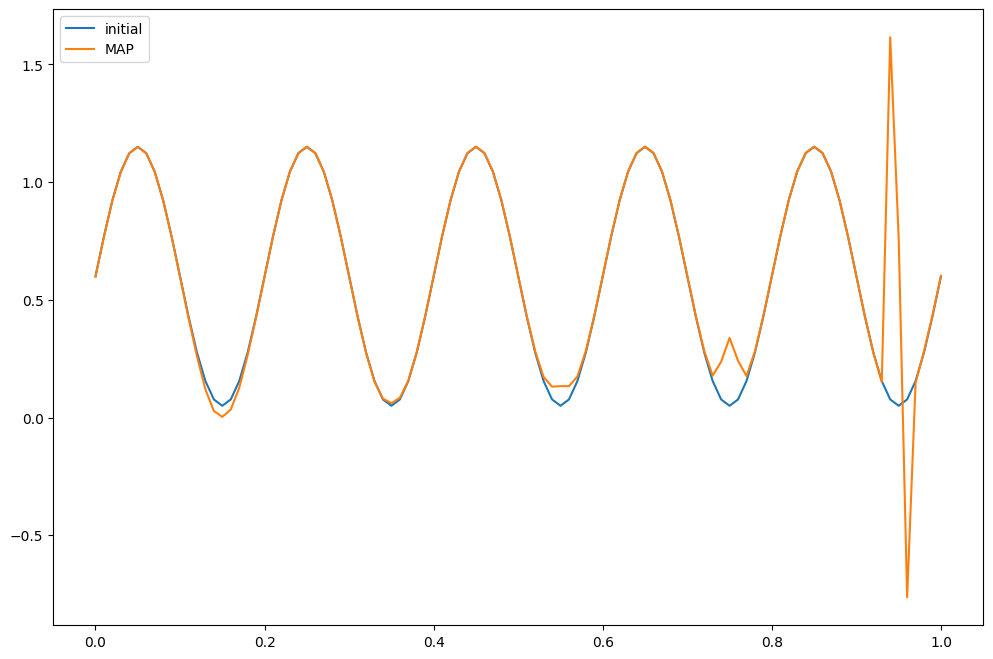

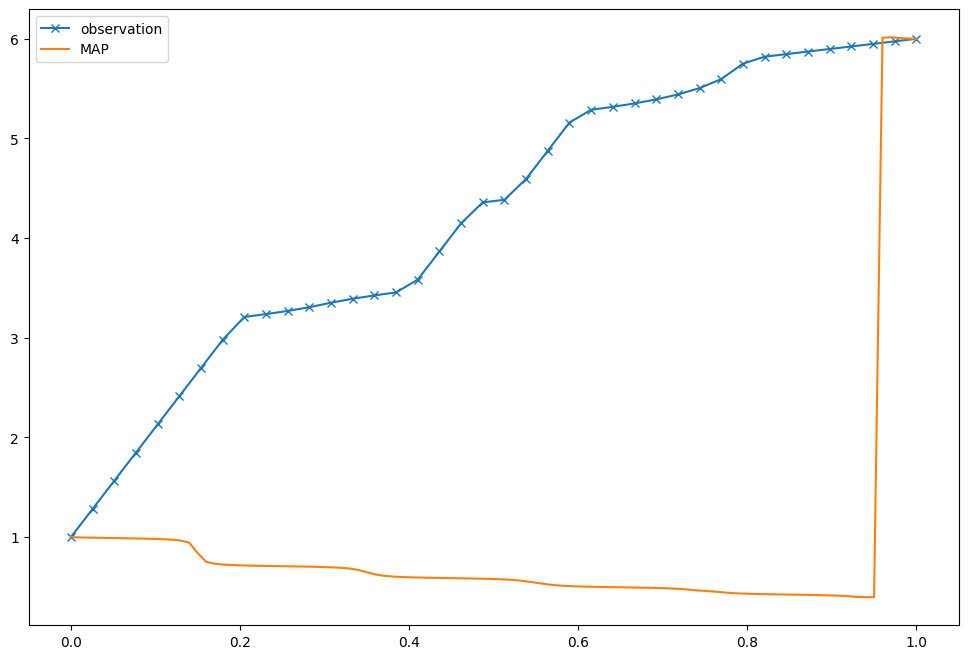

In [77]:
x_sim = np.linspace(0,1,101)
alpha_sim = alpha_sin(x_sim, amplitude=0.55, frequency=5.)

x_ref = np.linspace(0,1,10001)
alpha_ref = alpha_sin(x_ref, amplitude=0.55, frequency=5.)


alpha0 = alpha_sim
I0 = objfn.negated_compute_I(alpha0)
# alpha0 = alpha_ref
# print(f'alpha0: {alpha0}')


# fun = objfn.negated_compute_I(alpha0)
# print(f'fun: {fun}')
def callback(xk):
    print(f"Current parameter value: {xk}")
# result = minimize(fun = objfn*-1, x0 = alpha0, method='CG', jac =dIdalpha_adjoint)
# result = minimize(fun = objfn.negated_compute_I(alpha0, objfn.compute_I), x0 = alpha0, method='CG') #, jac =objfn.negated_compute_gradient_adjoint(alpha, objfn.compute_gradient_adjoint))
result = minimize(fun = objfn.negated_compute_I, x0 = alpha0, method='CG', jac =objfn.negated_compute_gradient_adjoint, options={'disp': True, 'maxiter': 1000}) #, callback = callback)
alpha_MAP = result.x
I_MAP = result.fun
u_alpha_MAP = solve_poisson(alpha_MAP,  0., U0, U1)

print(f'I0: {I0}, I_MAP: {I_MAP}')

plt.figure(figsize=(12,8))
plt.plot(x_sim, alpha0, label = 'initial')
plt.plot(x_sim, alpha_MAP, label = 'MAP')
plt.legend()


plt.figure(figsize=(12,8))
plt.plot(x_obs, u_obs, marker ='x', label = 'observation')
plt.plot(x_sim, u_alpha_MAP, label = 'MAP')
plt.legend()


**EXERCISE 6**

Of course it's no fun estimating a function ($\alpha$) that you already know.  The code below load observations of $u$ for some secret $\alpha$.  The observatations have a noise of $2\times 10^{-4}$.  The $\alpha$ that produced them spells out a 3-letter word. What is the word?


In [55]:
secret = loadmat(open('secret.mat', 'rb'))
x_obs, u_obs = secret['x_obs'][0], secret['u_obs'][0]
noise = 2.e-4

# Define your objective function with the new observations, reset the
# initial guess, and run the optimization (previous cell) again.
objfn = ObjectiveFn(x_sim, 0., U0, U1, x_obs, u_obs, noise, prior)
alpha0 = np.ones(101)